In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import seaborn as sns
df = sns.load_dataset("titanic")

In [3]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


### 앙상블 중 voting
- 실제 코드와 시각화를 통해서 어떤 식으로 구현되는지 확인해 보기!
- 랜덤포레스트 배깅, 부트스트래핑에 대한 예시

- voting을 통해
- LogisticRegression
- KNeighborsClassifier
- DecisionTreeClassifier

In [4]:
df_tt = df[["survived","pclass","fare"]]
df_tt.dropna(inplace=True)

C:\Users\doram\AppData\Local\Temp\ipykernel_22104\2514477028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tt.dropna(inplace=True)


In [5]:
df_tt

,survived,pclass,fare
0,0,3,7.2500
1,1,1,71.2833
2,1,3,7.9250
3,1,1,53.1000
4,0,3,8.0500
...,...,...,...
886,0,2,13.0000
887,1,1,30.0000
888,0,3,23.4500
889,1,1,30.0000


In [6]:
##### soft voting #####
# voting에 필요한 모델을 학습하자
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=3)
dt_clf = DecisionTreeClassifier()

# voting 불러오기
vo_clf = VotingClassifier(estimators=[("LR",lr_clf),("KNN",knn_clf),("DT",dt_clf)], 
                          voting="soft") # soft

feature = df_tt[["pclass","fare"]]
feature = np.array(feature)
X_train, X_test, y_train, y_test = train_test_split(feature, df_tt["survived"], test_size=0.2, random_state=111)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.7206703910614525


### voting 하이퍼파라미터
- estimators: 위의 모델링 선정하는 것
- voting: soft, hard
- weight: 가중치 (모델에 대한 가중치) [5,4,2] 가중치를 선정하는 것
- n_jobs
- 기타 구글링


- voting classifier, regression
- 2가지 가능하다.


- 각각 개별적으로 성능을 확인해 보자!

In [7]:
cls_ct = [lr_clf, knn_clf, dt_clf]

for cls in cls_ct:
    cls.fit(X_train, y_train)
    pred = cls.predict(X_test)
    class_name = cls.__class__.__name__
    print("{0} 정확도 {1:.4f}".format(class_name, accuracy_score(y_test, pred)))

LogisticRegression 정확도 0.6927
KNeighborsClassifier 정확도 0.7263
DecisionTreeClassifier 정확도 0.6983


- 데이터 800개밖에 안 되어서 voting이 좋아보이는 것
- 절대 voting이 좋은 건 아니다.

- voting의 파라미터를 수정해 보자!
- voting 파라미터를 수정할 수 있지만, 추가로 각 모델링에 대해서도 파라미터를 수정할 수 있다.
- 로지스틱, knn, dt에 대해서 최적의 파라미터를 찾고, 그것들을 다 모아서 voting으로 다시 돌릴 수 있다.
- 다 같이 묶어서 보팅으로 다시 돌려서 결과가 어떻게 나오는 지 확인도 가능하다.
- xgboost, lightgbm, cat, rf 묶어서 해보면 좋다.

In [8]:
##### soft voting w/ weighting #####
# voting에 필요한 모델을 학습하자
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=3)
dt_clf = DecisionTreeClassifier()

# voting 불러오기
vo_clf = VotingClassifier(estimators=[("LR",lr_clf),("KNN",knn_clf),("DT",dt_clf)], 
                          voting="soft", weights=[1,5,3]) # soft

feature = df_tt[["pclass","fare"]]
feature = np.array(feature)
X_train, X_test, y_train, y_test = train_test_split(feature, df_tt["survived"], test_size=0.2, random_state=111)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.6983240223463687


- 가중치를 선정할 때 보팅을 사용할 모델이 정확한 파라미터와 성능이 1차로 보증되어야 한다.
- 조금씩 수정을 하면서 변경할 수는 있을 것
- 위에 나와있는 모델에서 과적합이나 파라미터가 최적이 아닌 상태면 더 좋은 성능을 못 낼 수도 있다.


- 보팅이 너무나 좋은 성능을 보이는 건 아니다.
- 다양한 알고리즘들이 섞이다보니 복잡한 문제를 해결할 때 좋은 성능을 보일 수는 있다.

### hard 보팅
- soft 보팅을 사용했고, 이제는 hard 보팅을 사용해 보자!

In [9]:
##### hard voting w/ weighting #####
# voting에 필요한 모델을 학습하자
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=3)
dt_clf = DecisionTreeClassifier()

# voting 불러오기
vo_clf = VotingClassifier(estimators=[("LR",lr_clf),("KNN",knn_clf),("DT",dt_clf)], 
                          voting="hard", weights=[1,5,3]) # hard

feature = df_tt[["pclass","fare"]]
feature = np.array(feature)
X_train, X_test, y_train, y_test = train_test_split(feature, df_tt["survived"], test_size=0.2, random_state=111)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.7262569832402235


- 하드 보팅과 소프트 보팅이 구체적으로 어떤 차이가 있을까?
- 하드 보팅은
- lr_clf 1 예측, knn_clf 1 예측, dt_clf 0 예측
- 다수결로 진행하여 1로 예측
- lr_clf, knn_clf 잘몯된 예측을 하면 잘못된 의사결정이 된다.

- 소프트 보팅은
- 0, 1을 예측 타이타닉
- lr_clf [0,1] 확률로 바라보면 0.7 0.3
- knn_clf [0,1] 확률로 바라보면 0.2, 0.8
- df_clf [0,1] 확률로 바라보면 0.9, 0.1
- class의 평균으로 바라본다.
- [0,1] 0.6 0.4로 예측한다.

In [10]:
(0.7+0.2+0.9)/3

0.6

In [11]:
(0.3+0.8+0.1)/3

0.4000000000000001

C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ =

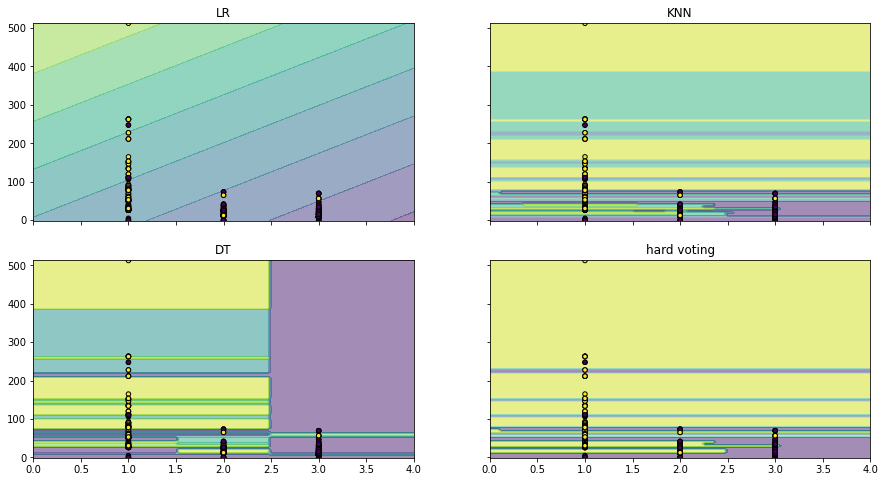

In [12]:
##### hard voting w/ weighting #####
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=3)
dt_clf = DecisionTreeClassifier()
vo_clf = VotingClassifier(estimators=[("LR",lr_clf),("KNN",knn_clf),("DT",dt_clf)], 
                          voting="hard", weights=[1,5,3]) # hard

lr_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
vo_clf.fit(X_train, y_train)

# 그래프 시각화 하기
import matplotlib.pyplot as plt
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay

f, ax_arr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(15,8))

for idx, clf, tt in zip(product([0,1],[0,1]), 
                        [lr_clf, knn_clf, dt_clf, vo_clf], 
                        ["LR", "KNN", "DT", "hard voting"]):
    DecisionBoundaryDisplay.from_estimator(
    clf, X_train, alpha=0.5, ax=ax_arr[idx[0],idx[1]], response_predict="predict")
    ax_arr[idx[0], idx[1]].scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor="k")
    ax_arr[idx[0], idx[1]].set_title(tt)

C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
C:\Users\doram\AppData\Roaming\Python\Python39\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'response_predict'
  self.surface_ =

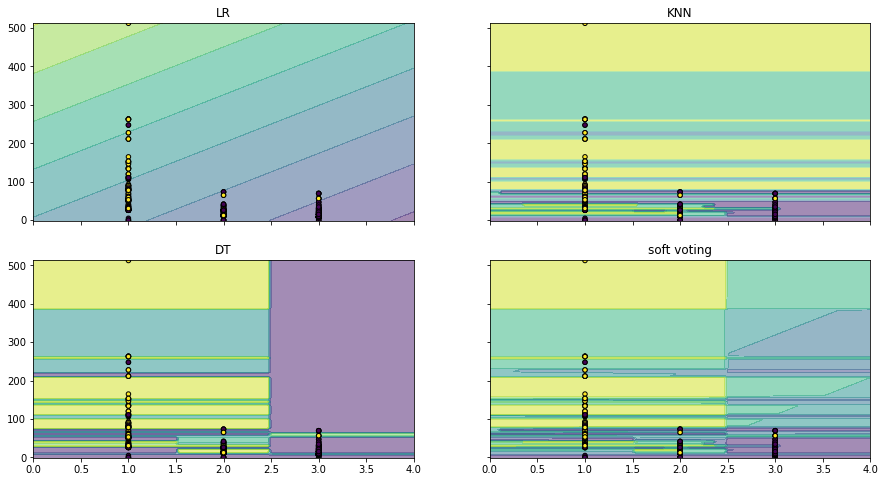

In [13]:
##### soft voting w/ weighting #####
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=3)
dt_clf = DecisionTreeClassifier()
vo_clf = VotingClassifier(estimators=[("LR",lr_clf),("KNN",knn_clf),("DT",dt_clf)], 
                          voting="soft", weights=[1,5,3]) # soft

lr_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
vo_clf.fit(X_train, y_train)

# 그래프 시각화 하기
import matplotlib.pyplot as plt
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay

f, ax_arr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(15,8))

for idx, clf, tt in zip(product([0,1],[0,1]), 
                        [lr_clf, knn_clf, dt_clf, vo_clf], 
                        ["LR", "KNN", "DT", "soft voting"]):
    DecisionBoundaryDisplay.from_estimator(
    clf, X_train, alpha=0.5, ax=ax_arr[idx[0],idx[1]], response_predict="predict")
    ax_arr[idx[0], idx[1]].scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor="k")
    ax_arr[idx[0], idx[1]].set_title(tt)

### 확률로 판단하여 시각화 확인하기
- 클래스에 대한 값을 판단하는지 체크해 보기

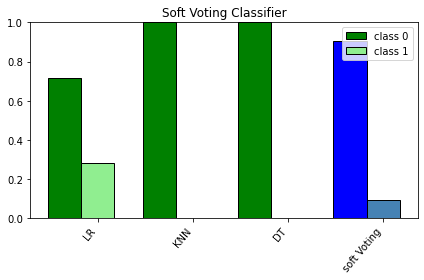

In [14]:
lr_clf = LogisticRegression(solver="liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=3)
dt_clf = DecisionTreeClassifier()
vo_clf = VotingClassifier(estimators=[("LR",lr_clf),("KNN",knn_clf),("DT",dt_clf)], 
                          voting="soft") # soft
probas = [c.fit(X_train, y_train).predict_proba(X_train) for c in (lr_clf, knn_clf, dt_clf, vo_clf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

# plotting
N = 4              # number of groups
ind = np.arange(N) # group positions
width = 0.35       # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color="green", edgecolor="k")
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color="lightgreen", edgecolor="k")

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width, color="blue", edgecolor="k")
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color="steelblue", edgecolor="k")

plt.axvline(2, 8, color="k", linestyle="dashed")
ax.set_xticks(ind + width)
ax.set_xticklabels(["LR", "KNN", "DT", "soft Voting"], rotation=50, ha="right")

plt.ylim([0, 1])
plt.title("Soft Voting Classifier")
plt.legend([p1[0], p2[0]], ["class 0", "class 1"], loc="upper right")
plt.tight_layout()
plt.show()

### 필수과제 1
- 기존에 공유드렸던 데이터 중에 직접 voting 모델링을 진행하고, 시각화까지 비교하면서
- 어떤 식으로 변화하는지에 대해서 정리해 주세요.
- 기본 베이스로만 먼저 보팅을 해보고 -> 그 다음은 튜닝으로 진행
- 우리가 배웠던 모델링의 하이퍼파라미터는 다 튜닝해 주셔야 합니다.
- 어떤 식으로 바뀌는지를 꼭 정리해 주세요!

### 랜덤포레스트
- 랜덤포레스트는 앙상블인데 배깅의 방식
- 앙상블이지만 모델을 여러개 사용하는 게 아니라 데이터를 서브셋으로 나눠서 여러개로 쪼개고 하나의 모델로 학습시키는 방식
- 데이터가 나눠지니까 부트스트래핑 방식 (bootstrapping) 분할 방식
- 배깅 + bootstrap
- 통계학에서 여러개의 작은 데이터셋을 임의로 만들어서 개별에 대한 평균이나 분산을 측정하기 위한 샘플링
- 랜덤포레스트는 이 방식을 이용해서 진행하는 것
- 데이터셋이 임의로 만들어지고 이 데이터셋을 여러개로 나눠서 학습한다.
- 개별 데이터가 중첩되어서도 만들어진다.

---
- ex)
- [파문기, 파문응, 데분기, 데분중, SQL]

- 서브셋 1
- [파문기, 파문기, 파문기, 파문응, 데분기]
- 서브셋 2
- [데분기, 파문응, 데분중, SQL, 파문응]
- 서브셋 3
- [파문기, 파문응, 파문응, 데분중, 데분중]

---
- 해당 서브셋이 나눠지면 그 데이터를 가지고 학습을 한다 -> 부트스트래핑 분할이라고 한다.
- Random Forest라고 명칭하고 개별 데이터셋에 결정 트리 분류기를 적용하는 것
- 기존 DT와는 다르게 얘는 데이터를 랜덤하게 서브로 나누기 때문에 과적합에 대해서 어느정도 안정성이 있다.
- 과적합을 줄일 수 있다.

### 프로젝트에 대해서 사전에 미리 준비하기
- 주제는 자유주제
- 개인 또는 팀별 진행
- 팀이 진행하는 경우는 팀으로만 1번 제출하기
- 네이버 카페에 꼭 제출해야 한다.